# Demonstration of Different Clipping Methods

This notebook is a demonstration showing different outcomes from clipping methods when clipping a raster to a box with rioxarray. We noticed differences when using the inbuilt `crs=` parameter and when we transformed the `crs` ourselves. This shows those through plotting, and also shows the effects of `all_touched=True` on there. 

In [1]:
from glob import glob
import os
import warnings

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import geopandas as gpd
from shapely.geometry import box, Polygon
from rasterio import warp

import earthpy as et
import earthpy.plot as ep

et.data.get_data('cs-test-naip')
et.data.get_data('cold-springs-fire')
et.data.get_data('cold-springs-modis-h4')
et.data.get_data(url="https://ndownloader.figshare.com/files/21941085")

os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))
warnings.simplefilter('ignore')

rioxarray_option = rxr.set_options(export_grid_mapping=False)

# Functions

These functions clip the data and use all_touched slightly differently!

In [2]:
def open_clean_bands_crop_1(band_path,
                            crop_bound,
                            valid_range=None,
                            variable=None,
                            all_touched=False):
    """Open and clean a single band, with the boundary of a box, converting the crs using rioxarray.
    """

    crop_bound_box = [box(*crop_bound.total_bounds)]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True,
                                 variable=variable).rio.clip(crop_bound_box,
                                                             crs=crop_bound.crs,
                                                             all_touched=all_touched,
                                                             from_disk=True).squeeze()
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    # Only mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band


def open_clean_bands_crop_2(band_path,
                            crop_bound,
                            valid_range=None,
                            variable=None,
                            all_touched=False):
    """Open and clean a single band, with the boundary of a box, converting the crs before using rioxarray.
    """

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True,
                                 variable=variable)

        crop_bounds = crop_bound.to_crs(band.rio.crs)
        crop_bound_box = [box(*crop_bounds.total_bounds)]

        band = band.rio.clip(crop_bound_box,
                             all_touched=all_touched,
                             from_disk=True).squeeze()
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    # Only mask the data to the valid range if a valid range tuple is provided
    if valid_range is not None:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band


def run_functions(band_path,
                  crop_bound,
                  valid_range=None,
                  variable=None):
    """Helper function for this notebook to make running all the variations of the function cleaner."""
    arr_1 = open_clean_bands_crop_1(band_path,
                                    crop_bound,
                                    valid_range,
                                    variable,
                                    True)

    arr_2 = open_clean_bands_crop_2(band_path,
                                    crop_bound,
                                    valid_range,
                                    variable,
                                    True)

    arr_3 = open_clean_bands_crop_1(band_path,
                                    crop_bound,
                                    valid_range,
                                    variable,
                                    False)

    arr_4 = open_clean_bands_crop_2(band_path,
                                    crop_bound,
                                    valid_range,
                                    variable,
                                    False)

    return [arr_1, arr_2, arr_3, arr_4]

## Opening the Fire Boundary Data

In [3]:
# Open fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary = gpd.read_file(fire_boundary_path)

## Opening and Cropping the Landsat Data in 4 Ways

In [4]:
data_path = os.path.join("earthpy-downloads",
                         "landsat-coldsprings-hw")

all_files = sorted(glob(os.path.join(
    data_path, "LC080340322016062101T1-SC20200306230017", "*band[3-7]*.tif")))

# Crop and clean data
all_landsat_arrays = []

for a_band in all_files:
    landsat_arrays = run_functions(a_band,
                                   fire_boundary,
                                   valid_range=(0, 10000))

    all_landsat_arrays.append(landsat_arrays)

all_landsat_arrays = list(zip(*all_landsat_arrays[::1]))

concatted_arrays = []

for array in all_landsat_arrays:
    concatted_arrays.append(xr.concat(array, dim="band"))

fire_bound_utmz13 = fire_boundary.to_crs(concatted_arrays[0].rio.crs)

extent_landsat = plotting_extent(
    concatted_arrays[0][0], concatted_arrays[0].rio.transform())

## Opening and Cropping the MODIS Data in 4 Ways

In [5]:
# Process MODIS Data

desired_bands = ["sur_refl_b01_1", "sur_refl_b02_1",
                 "sur_refl_b04_1", "sur_refl_b07_1"]

modis_h4_path = glob(os.path.join(
    "cold-springs-modis-h4", "17_july_2016", "*.hdf"))[0]

modis_arrays = run_functions(modis_h4_path,
                             fire_boundary,
                             valid_range=(0, 10000),
                             variable=desired_bands)

# Reproject fire boundary
fire_bound_sin = fire_boundary.to_crs(modis_arrays[0].rio.crs)
extent_modis_post = plotting_extent(modis_arrays[0].sur_refl_b01_1.values,
                                    modis_arrays[0].rio.transform())

## Creating the Bounds Used for Cropping 

In [6]:
# Creating bounds for plotting

fire_box = [box(*fire_boundary.total_bounds)]
landsat_crs = concatted_arrays[0].rio.crs
modis_crs = modis_arrays[0].rio.crs

landsat_box = gpd.GeoDataFrame(geometry=[box(*fire_bound_utmz13.total_bounds)])
modis_box = gpd.GeoDataFrame(geometry=[box(*fire_bound_sin.total_bounds)])

landsat_transform = warp.transform_geom(
    fire_boundary.crs, landsat_crs, fire_box)
landsat_transformed_bounds = gpd.GeoDataFrame(geometry=[Polygon(
    landsat_transform[0]['coordinates'][0][::1])], crs=landsat_crs)

modis_transform = warp.transform_geom(fire_boundary.crs, modis_crs, fire_box)
modis_transformed_bounds = gpd.GeoDataFrame(
    geometry=[Polygon(modis_transform[0]['coordinates'][0][::1])], crs=modis_crs)

In [7]:
def clean_array_plot(xr_obj):
    # This function takes a single xarray object as an input and produces a
    # cleaned numpy array output for plotting

    return ma.masked_array(xr_obj.values,  xr_obj.isnull())

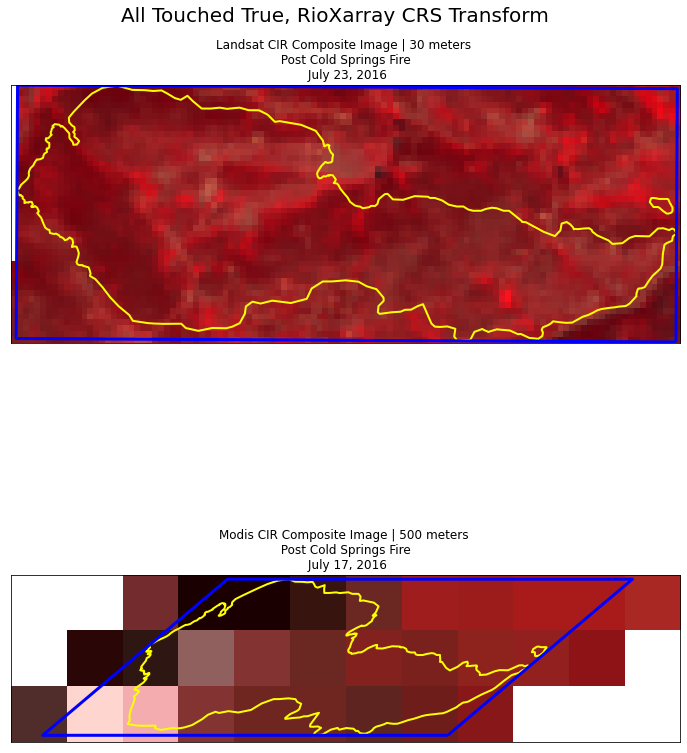

In [8]:
landsat_plot = clean_array_plot(concatted_arrays[0])
modis_plot = clean_array_plot(modis_arrays[0].to_array())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 15))

fig.suptitle("All Touched True, RioXarray CRS Transform", y=.9, fontsize=20)

ep.plot_rgb(landsat_plot, ax=ax1, rgb=[2, 1, 0],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 23, 2016",
            extent=extent_landsat)
fire_bound_utmz13.plot(ax=ax1,
                       color='None',
                       edgecolor='yellow',
                       linewidth=2)

landsat_transformed_bounds.boundary.plot(ax=ax1,
                                         color='blue',
                                         linewidth=3)

ep.plot_rgb(modis_plot,
            ax=ax2,
            rgb=[1, 0, 2],
            title="Modis CIR Composite Image | 500 meters \n Post Cold Springs Fire \n July 17, 2016",
            extent=extent_modis_post)

fire_bound_sin.plot(ax=ax2,
                    color='None',
                    edgecolor='yellow',
                    linewidth=2)

modis_transformed_bounds.boundary.plot(ax=ax2,
                                       color='blue',
                                       linewidth=3)
plt.show()

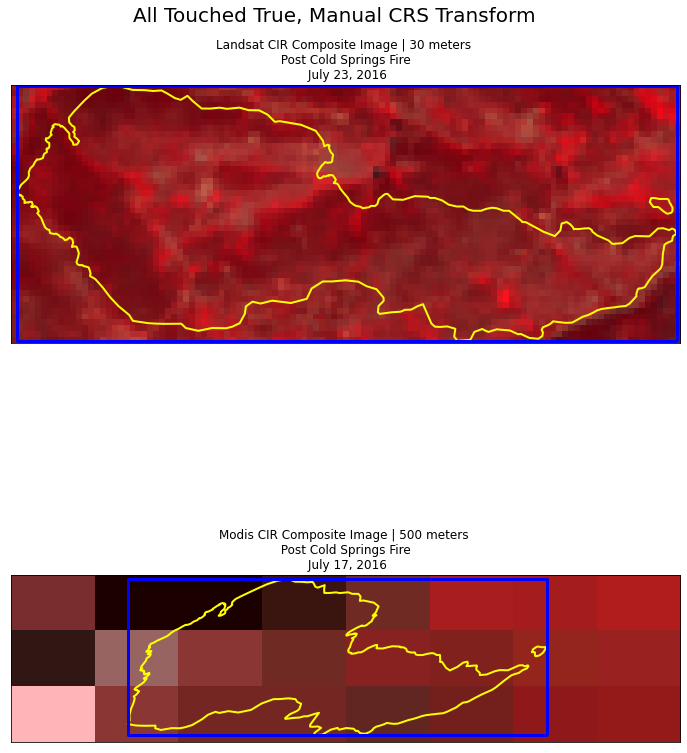

In [9]:
landsat_plot = clean_array_plot(concatted_arrays[1])
modis_plot = clean_array_plot(modis_arrays[1].to_array())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 15))

fig.suptitle("All Touched True, Manual CRS Transform", y=.9, fontsize=20)

ep.plot_rgb(landsat_plot, ax=ax1, rgb=[2, 1, 0],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 23, 2016",
            extent=extent_landsat)
fire_bound_utmz13.plot(ax=ax1,
                       color='None',
                       edgecolor='yellow',
                       linewidth=2)

landsat_box.boundary.plot(ax=ax1,
                          color='blue',
                          linewidth=3)

ep.plot_rgb(modis_plot,
            ax=ax2,
            rgb=[1, 0, 2],
            title="Modis CIR Composite Image | 500 meters \n Post Cold Springs Fire \n July 17, 2016",
            extent=extent_modis_post)

fire_bound_sin.plot(ax=ax2,
                    color='None',
                    edgecolor='yellow',
                    linewidth=2)

modis_box.boundary.plot(ax=ax2,
                        color='blue',
                        linewidth=3)

plt.show()

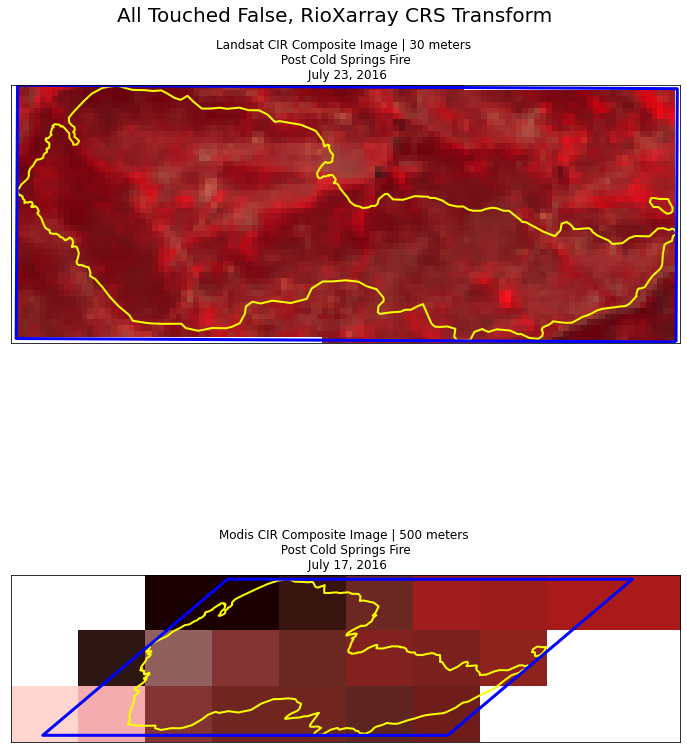

In [10]:
landsat_plot = clean_array_plot(concatted_arrays[2])
modis_plot = clean_array_plot(modis_arrays[2].to_array())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 15))

fig.suptitle("All Touched False, RioXarray CRS Transform", y=.9, fontsize=20)

ep.plot_rgb(landsat_plot, ax=ax1, rgb=[2, 1, 0],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 23, 2016",
            extent=extent_landsat)
fire_bound_utmz13.plot(ax=ax1,
                       color='None',
                       edgecolor='yellow',
                       linewidth=2)

landsat_transformed_bounds.boundary.plot(ax=ax1,
                                         color='blue',
                                         linewidth=3)

ep.plot_rgb(modis_plot,
            ax=ax2,
            rgb=[1, 0, 2],
            title="Modis CIR Composite Image | 500 meters \n Post Cold Springs Fire \n July 17, 2016",
            extent=extent_modis_post)

fire_bound_sin.plot(ax=ax2,
                    color='None',
                    edgecolor='yellow',
                    linewidth=2)

modis_transformed_bounds.boundary.plot(ax=ax2,
                                       color='blue',
                                       linewidth=3)
plt.show()

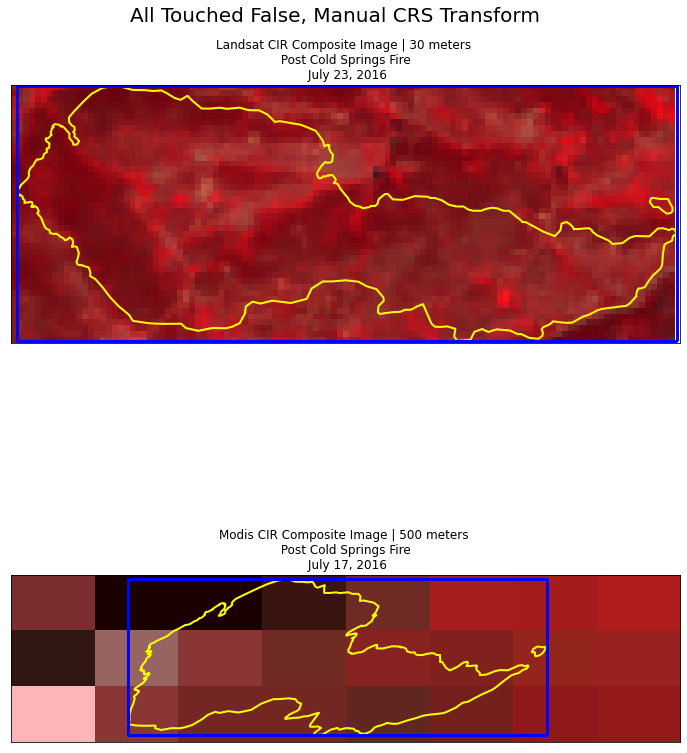

In [11]:
landsat_plot = clean_array_plot(concatted_arrays[3])
modis_plot = clean_array_plot(modis_arrays[3].to_array())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 15))

fig.suptitle("All Touched False, Manual CRS Transform", y=.9, fontsize=20)

ep.plot_rgb(landsat_plot, ax=ax1, rgb=[2, 1, 0],
            title="Landsat CIR Composite Image | 30 meters \n Post Cold Springs Fire \n July 23, 2016",
            extent=extent_landsat)
fire_bound_utmz13.plot(ax=ax1,
                       color='None',
                       edgecolor='yellow',
                       linewidth=2)

landsat_box.boundary.plot(ax=ax1,
                          color='blue',
                          linewidth=3)

ep.plot_rgb(modis_plot,
            ax=ax2,
            rgb=[1, 0, 2],
            title="Modis CIR Composite Image | 500 meters \n Post Cold Springs Fire \n July 17, 2016",
            extent=extent_modis_post)

fire_bound_sin.plot(ax=ax2,
                    color='None',
                    edgecolor='yellow',
                    linewidth=2)

modis_box.boundary.plot(ax=ax2,
                        color='blue',
                        linewidth=3)
plt.show()